# Senior Isolation Notebook

Loneliness and social isolation among senior citizens is a prevalent problem among the elderly today. The COVID-19 Pandemic has only made conditions worse. This notebook contains the source code for the visualizations and data analysis in my report, *Senior Isolation in the Age of COVID-19: How Project Blue Star is Taking an Evidence-Based Approach to Help*. You can access the full report [HERE](https://projectbluestar.herokuapp.com/our-mission).


## Setup:

This section includes the code for how I imported, cleaned, and formatted the raw data from Altarum, the Health and Retirement Study, and National Social Life, Health, and Ageing Project.

In [49]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functools import reduce
from scipy.stats import ttest_ind
from scipy.interpolate import UnivariateSpline

#setting basic styles and formatting for plots
%matplotlib inline 
plt.style.use("seaborn")

I first read in csv files from Altarum. I generated these manually by using the data presented in [this report by Altarum](https://altarum.org/sites/default/files/uploaded-publication-files/Nursing-Home-Resident-Survey_Altarum-Special-Report_FINAL.pdf).

In [50]:
#reading altarum csv files, formatting dataframes
altarum_loneliness = pd.read_csv('Data/altarum_loneliness_data.csv')
altarum_visitors = pd.read_csv('Data/altarum_visitors_per_week_data.csv')


altarum_loneliness = altarum_loneliness.set_index('Unnamed: 0')
altarum_visitors = altarum_visitors.set_index('Unnamed: 0')

Next, I read in data from the Health and Retirement Study (HRS) [Public Survey Data](https://hrsdata.isr.umich.edu/data-products/public-survey-data). The HRS is a biennial, US National study of older adults. Although it collects extensive data on retirement and finances among the elderly, it also collects information on physical health (as a part of the main survey/interview) and psychosocial health (through Leave-Behind Questionaires). 

The HRS, through their [website](https://hrsdata.isr.umich.edu/data-products/public-survey-data), only export data in a .da file format. In order to extract the data, I had to run the original data through a SAS program (provided by HRS) and then download the .sas7bdat files to my machine to be read and analyzed with pandas. 

hrs1X_lb dataframes contain data from the leave-behind questionaires with psychosocial data. hrs1X_n dataframes contain data from the "Health Services and Insurance" datasets. hrs1X_prr datasets contain data from the "Preload (Respondent)" datasets. I read in data from 2012-2018 surveys. **NOTE:** HRS 2018 data is still in 'EARLY RELEASE' -- I accessed the data on 7/19/2021: Version 1.0

In [51]:
#reading HRS data from .sas7bdat files, generated from original .da files given by HRS using SAS software
hrs12_lb = pd.read_sas('Data\h12lb_r.sas7bdat')
hrs12_n = pd.read_sas('Data\h12n_r.sas7bdat')
hrs12_prr = pd.read_sas('Data\h12pr_r.sas7bdat')

hrs14_lb = pd.read_sas('Data\h14lb_r.sas7bdat')
hrs14_n = pd.read_sas('Data\h14n_r.sas7bdat')
hrs14_prr = pd.read_sas('Data\h14pr_r.sas7bdat')

hrs16_lb = pd.read_sas('Data\h16lb_r.sas7bdat')
hrs16_n = pd.read_sas('Data\h16n_r.sas7bdat')
hrs16_prr = pd.read_sas('Data\h16pr_r.sas7bdat')

hrs18_lb = pd.read_sas('Data\h18lb_r.sas7bdat')
hrs18_n = pd.read_sas('Data\h18n_r.sas7bdat')
hrs18_prr = pd.read_sas('Data\h18pr_r.sas7bdat')

#WARNING: from pd.read_sas; known bug in python pandas, has no impact on the data

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


Below, I read in data from the [National Social Life, Health and Ageing Project Round 3](https://www.icpsr.umich.edu/web/NACDA/studies/36873) (conducted in 2015-2016). Although smaller in sample size than the HRS, it contains rich data about the social life and overall health of older adults in the US. It contains an oversampling of African Americans, Hispanics and older men ([O’Muircheartaigh et al.](https://academic.oup.com/psychsocgerontology/article/64B/suppl_1/i12/555593)). 

According to the codebook, I set all values less than 0 (which, depending on the question, could mean missing data, no response, etc) to NaN values such that I could easily drop them from the dataframes later on

In [52]:
nshap_ds1 = pd.read_csv('Data/36873-0001-Data.tsv', sep='\t', na_values=np.arange(-20, 0))

Below, I define the basic functions for cleaning the HRS data. Each dataframe read in from the raw .sas7bdat files, will be ran through the merge_hrs function. Here, I will provide a brief explanation of each function.

det_lonely(df): This function takes a dataframe as an input and outputs the same dataframe, but with a new column titled 'lonely_yn'. This column contains boolean (True/False) values for whether the respondent in each row is considered lonely. This determination is based on the validated 3-Item version of the UCLA Loneliness Scale developed by [Hughes, et al.](https://journals.sagepub.com/doi/10.1177/0164027504268574). A respondent was labeled as 'lonely' if they responded 'Some of the time' or 'Often' to any one of the questions in the questionairre. This determination is consistent with other similar studies which also had to make a split between 'lonely' and 'not lonely' ([Perissnotto et al.](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/1188033)). 

clean_id(df): This function takes a dataframe as an input and outputs the same dataframe but with a standardized HHID (House Hold Identification Number) and PN (Respondent Identification Number) as integers. The raw data had abnormal formatting that would have made merging lb, n, and prr dataframes tricky.

det_age(df, year) This function takes a dataframe as input and outputs the same dataframe but with a new column that has the age of each respondent at the time of the interview. This is calculated by using the respondent's birth year * -1 + current year.

def score_loneliness(df): This function takes a dataframe as input and outputs the same dataframe but with a new column that has the loneliness score (3-9) based on the 3-Item version of the UCLA Loneliness Scale developed by [Hughes, et al.](https://journals.sagepub.com/doi/10.1177/0164027504268574).

def merge_hrs(df1, df2, df3, int_year): creates merged HRS dataframe from raw PR-R, LB, and N dataframes; determines if lonely (y/n), determines age, and cleans ids; drops rows without necessary data; cleans N100 column; scores loneliness; filters out columns with unneeded information.

In [53]:
hrs_nadrop = ['NX067_R', 'NLB020A', 'NLB020B', 'NLB020C', 'NN147', 'NN099']

hrs_relevant = ['HHID', 'PN', 'NX067_R', 'ages', 'NLB020A', 'NLB020B', 'NLB020C', 'lonely_yn', 'lonely_score',
                            'NN099', 'NN100', 'NN101', 'NN147', 'NN207']


#determine if lonely; respondent is lonely when 'NLB020A', 'NLB020B', or 'NLB020C' has value as < 3 (rationale above)
def det_lonely(df):
    lonely_yn_df = df.copy()
    lonely_yn_df['lonely_yn'] = False

    lonely_yn_df['lonely_yn'] = lonely_yn_df[(lonely_yn_df['NLB020A'] < 3) | (lonely_yn_df['NLB020B'] < 3) | 
                                          (lonely_yn_df['NLB020C'] < 3)]['lonely_yn'].map({False: True})
    lonely_yn_df['lonely_yn'] = lonely_yn_df['lonely_yn'].fillna(False)
    
    return lonely_yn_df


#data read in from HRS has non-integer identification numbers (HHID and PN); this function standardizes them as integers
def clean_id(df):
    cleaned_df =  df.copy()
    #using string slicing to clean HHID and PN identification numbers as clean integers
    cleaned_df[['HHID', 'PN']] = cleaned_df[['HHID', 'PN']].astype(str).applymap(lambda x: x[2:-1]).astype(int)
    return cleaned_df


#data from HRS only provides year of birth; this function uses survey year and birth year to calculate age in new column 'ages'
def det_age(df, year):
    aged_df = df.copy()
    aged_df['ages'] = aged_df['NX067_R']
    aged_df.ages = aged_df.loc[:, 'ages'].apply(lambda x: x * -1 + year)
    return aged_df

#scoring loneliness: reverse scored such that max score (most lonely) = 9; min score (least lonely) = 3 (UCLA 3 Item)
def score_loneliness(df):
    scored_df = df.copy()
    scored_df['lonely_score'] = scored_df.apply(lambda x: 12 - (x['NLB020A'] + x['NLB020B'] + x['NLB020C']), axis=1)
    return scored_df


def merge_hrs(df1, df2, df3, int_year):
    merged_df = reduce(lambda  left,right: pd.merge(left,right, on=['HHID', 'PN'], how='outer'), [df1, df2, df3])
    
    #dropping participants with ANY blank values within the necessary fields
    merged_df_drop = merged_df.dropna(axis='index', how='any', subset=hrs_nadrop)
    
    #determine if 'lonely' according to definition, add to new column
    merged_lonely_yn = det_lonely(merged_df_drop) 
    
    #clean HHID and PN
    merged_cid = clean_id(merged_lonely_yn)
    
    #determine age from birth year and year of interview, add to new column
    merged_aged = det_age(merged_cid, int_year)
    
    #set NaN values in N100 (number of nights spent in hospital) to zero; HRS data codebook implies NaN values mean 0 nights
    merged_aged['NN100'] = merged_aged['NN100'].fillna(0)
    
        
    #determine reverse-scored loneliness score, add to new column
    merged_scored = score_loneliness(merged_aged)
    
    #get only relevent columns in final merged df
    merged_final = merged_scored[hrs_relevant]

    return merged_final

When first creating this project, I used the 2012 HRS data to explore the data. In order to apply the same functions I used on the HRS 2012 data on the HRS 2014, HRS 2016, and HRS 2018 data, I had to rename columns on the more recent datasets to the corresponding columns in the 2012 dataset.

In [54]:
#defining function that will take df and a dictionary to rename columns in the dataframe
def rename_col(df, dictionary):
    renamed_df = df.copy()
    renamed_df.rename(dictionary, axis=1, inplace=True)
    return renamed_df

#creating python dictionaries to connect relevant columns to the corresponding HRS 2012 columns
hrs14_lb_rename = {'OLB019A':'NLB020A', 'OLB019B':'NLB020B', 'OLB019C':'NLB020C'}
hrs14_n_rename = {'ON099':'NN099', 'ON100':'NN100', 'ON101':'NN101', 'ON147':'NN147', 'ON207':'NN207'}
hrs14_prr_rename = {'OX067_R':'NX067_R'}

hrs16_lb_rename = {'PLB019A':'NLB020A', 'PLB019B':'NLB020B', 'PLB019C':'NLB020C'}
hrs16_n_rename = {'PN099':'NN099', 'PN100':'NN100', 'PN101':'NN101', 'PN147':'NN147', 'PN207':'NN207'}
hrs16_prr_rename = {'PX067_R':'NX067_R'}

hrs18_lb_rename = {'QLB019A':'NLB020A', 'QLB019B':'NLB020B', 'QLB019C':'NLB020C'}
hrs18_n_rename = {'QN099':'NN099', 'QN100':'NN100', 'QN101':'NN101', 'QN147':'NN147', 'QN207':'NN207'}
hrs18_prr_rename = {'QX067_R':'NX067_R'}

hrs14_lbr = rename_col(hrs14_lb, hrs14_lb_rename)
hrs14_nr = rename_col(hrs14_n, hrs14_n_rename)
hrs14_prrr = rename_col(hrs14_prr, hrs14_prr_rename)

hrs16_lbr = rename_col(hrs16_lb, hrs16_lb_rename)
hrs16_nr = rename_col(hrs16_n, hrs16_n_rename)
hrs16_prrr = rename_col(hrs16_prr, hrs16_prr_rename)

hrs18_lbr = rename_col(hrs18_lb, hrs18_lb_rename)
hrs18_nr = rename_col(hrs18_n, hrs18_n_rename)
hrs18_prrr = rename_col(hrs18_prr, hrs18_prr_rename)

Below, I apply the merge_hrs function to each of the dataframes such that I am left with 4 merged datasets, ready for analysis. 

In [55]:
#creating merged HRS dataframes: cleaned and standarized for analysis 
hrs12m = merge_hrs(hrs12_lb, hrs12_n, hrs12_prr, 2012)
hrs14m = merge_hrs(hrs14_lbr, hrs14_nr, hrs14_prrr, 2014)
hrs16m = merge_hrs(hrs16_lbr, hrs16_nr, hrs16_prrr, 2016)
hrs18m = merge_hrs(hrs18_lbr, hrs18_nr, hrs18_prrr, 2018)

Next, I move on to cleaning the raw NSHAP data. Here, I will provide a brief description of each of the functions: 

nshap_score_loneliness(df): Much like for the HRS data, uses the 3-Item version of the UCLA Loneliness Scale developed by [Hughes, et al.](https://journals.sagepub.com/doi/10.1177/0164027504268574). With this function, I again score the loneliness of each participant. The previous function could not work here because the numeric values of each response was different in the NSHAP data and the HRS data. 

nshap_score_anxiety(df): This function scores anxiety based on the 7-item anxiety subscale of the [Hospital Anxiety and Depression Scale](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1600-0447.1983.tb09716.x?sid=nlm%3Apubmed)([Mykletun, et al.](https://www.scopus.com/record/display.uri?eid=2-s2.0-0035672473&origin=inward&txGid=d3804bd39c228c548dabb7b565d203e0)). 

nshap_score_depression(df): This function scores depression based on the Center for Epidemiological Studies-Depression Minus Loneliness (CES-D-ML) scale ([Cacioppo, et al.](https://doi.apa.org/doiLanding?doi=10.1037%2F0882-7974.21.1.140)).


nshap_score_pstress(df): This function scores percieved stress based on the [Perceived Stress Scale- 4 Item (PSS)](https://macses.ucsf.edu/research/psychosocial/pss4.php).

In [56]:
relevant_nshap_columns = ['ID', 'AGE', 'COMPANION2', 'LEFTOUT2', 'ISOLATED2', 'lonely_score', 'FLTTENS', 'FRIGHT', 
                            'WORRY', 'RELAXED', 'BUTRFLY', 'RESTLES', 'PANIC', 'anxiety_score', 'NOTEAT', 'FLTDEP', 
                            'FLTEFF', 'NOSLEEP', 'WASHAPY', 'WASLONLY', 'UNFRIEND', 'ENJLIFE', 'FLTSAD', 'DISLIKD', 
                            'NOTGETGO',  'depression_score', 'UNCNTRL', 'CONFIDNT', 'GOMYWAY', 'PILEDIFF', 'pstress_score']

dropna_nshap_columns = ['ID', 'AGE', 'COMPANION2', 'LEFTOUT2', 'ISOLATED2', 'FLTTENS', 'FRIGHT', 
                            'WORRY', 'RELAXED', 'BUTRFLY', 'RESTLES', 'PANIC',  'NOTEAT', 'FLTDEP', 
                            'FLTEFF', 'NOSLEEP', 'WASHAPY', 'WASLONLY', 'UNFRIEND', 'ENJLIFE',
                            'FLTSAD', 'DISLIKD', 'NOTGETGO', 'UNCNTRL', 'CONFIDNT', 'GOMYWAY', 'PILEDIFF']

#scoring loneliness: scored such that max score (most lonely) = 9; min score (least lonely) = 0 (UCLA 3 Item)
def nshap_score_loneliness(df):
    scored_df = df.copy()
    scored_df['lonely_score'] = scored_df.apply(lambda x: x['COMPANION2'] + x['LEFTOUT2'] + x['ISOLATED2'], axis=1)
    return scored_df


#scoring anxiety: scored such that max score (most anxious) = 28; min score (least anxious) = 0 
#(Hospital Anxiety and Depression Scale; HADS)
def nshap_score_anxiety(df):
    scored_df = df.copy()
    scored_df['anxiety_score'] = scored_df.apply(lambda x: x['FLTTENS'] + x['FRIGHT'] + x['WORRY'] + 
                                x['RELAXED'] + x['BUTRFLY'] + x['RESTLES'] + x['PANIC'], axis=1)
    return scored_df

#scoring depression: scored such that max score (most depressed) = 44; min score (least depressed) = 0 
#(Center for Epidemiological Studies-Depression Minus Loneliness; CES-D)
def nshap_score_depression(df):
    scored_df = df.copy()
    scored_df['depression_score'] = scored_df.apply(lambda x: x['NOTEAT'] + x['FLTDEP'] + x['FLTEFF'] + 
                                x['NOSLEEP'] + x['WASHAPY'] + x['WASLONLY'] + x['UNFRIEND'] + x['ENJLIFE'] +
                                x['FLTSAD'] + x['DISLIKD'] + x['NOTGETGO'], axis=1)
    return scored_df

#scoring percieved stress: scored such that max score (most percievd stress) = 16; min score (least percieved stress) = 0 
#(Perceived Stress Scale- 4 Item; PSS)
def nshap_score_pstress(df):
    scored_df = df.copy()
    scored_df['pstress_score'] = scored_df.apply(lambda x: x['UNCNTRL'] + (4 - x['CONFIDNT']) + (4 - x['GOMYWAY']) + 
                                                 x['PILEDIFF'], axis=1)
    return scored_df

Below, I put the NSHAP data through the previously defined function to get a final NSHAP dataset, ready for analysis.

In [57]:
#dropping participants with ANY blank values within the necessary fields
nshap_clean = nshap_ds1.dropna(axis='index', how='any', subset=dropna_nshap_columns)

#putting nshap dataframe through the functions taht determine loneliness, anxiety, depression, and percieved stress scores
nshap_lscore = nshap_score_loneliness(nshap_clean)
nshap_ascore = nshap_score_anxiety(nshap_lscore)
nshap_dscore = nshap_score_depression(nshap_ascore)
nshap_psscore = nshap_score_pstress(nshap_dscore)

#getting a final NSHAP dataframe with only relevant columns
nshap_f = nshap_psscore[relevant_nshap_columns]

## HRS: Loneliness with Age

In thsi section, I use HRS data to create data visuals that plot loneliness with age. I first define the function apply_spline which first finds the mean loneliness score (based in the UCLA 3-Item Scale) by age and places them in a series. i limit which ages I apply this function to, because some ages (>95, for example) have very few data points (<10) such that they would likely be unrepresentative of the population. I also create a series with all the ages within the dataset. Lastly, I apply UnivariateSpline function from SciPy to create a smoothing spline to the data. This will allow me to plot a smooth regression line through the points to show a general trend in loneliness with age. 

In [58]:
#applying smoothing spline to data using UnivariateSpline function in SciPy
def apply_spline(df, lower_lim, upper_lim): 
    dfc = df.copy()
    #chose upper and lower limit depending survey year and data available
    dfc_c = dfc[(dfc['ages'] >= lower_lim) & (dfc['ages'] <= upper_lim)]

    dfc_scores = dfc_c.groupby('ages').lonely_score.mean()
    dfc_ages = dfc_scores.index
    spl = UnivariateSpline(dfc_ages, dfc_scores)
    return [dfc_ages, dfc_scores, spl]

Below, I apply the smoothing_spline function to all the HRS datasets to produce insightful plots about the general trend of loneliness score with age. The results found are generally consistent with those found by [Hawkley, et al.](https://www.apa.org/pubs/journals/releases/pag-pag0000365.pdf).

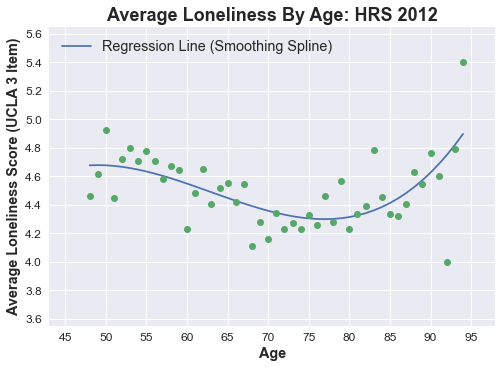

In [59]:
#using apply_spline() to get spline data to plot; chose upper and lower limit based on data available
hrs12_splined = apply_spline(hrs12m, 48, 94)
hrs12_rawx = hrs12_splined[0]
hrs12_rawy = hrs12_splined[1]
hrs12_spline = hrs12_splined[2]

#rendering plot with regression line and actual points
plt.title("Average Loneliness By Age: HRS 2012", fontsize=18, fontweight='bold')
plt.plot(hrs12_rawx, hrs12_spline(hrs12_rawx), label='Regression Line (Smoothing Spline)')
plt.plot(hrs12_rawx, hrs12_rawy, 'o')

plt.xlabel('Age', fontsize='x-large', fontweight='bold')
plt.ylabel('Average Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(45, 100, 5),  fontsize='large')
#plt.yticks(ticks=np.arange(3.6, 5.6, .2),  fontsize='large')
#plt.xlim(43, 98)
#plt.ylim(3.55, 5.5)

plt.yticks(ticks=np.arange(3.6, 5.8, .2),  fontsize='large')
plt.xlim(43, 98)
plt.ylim(3.55, 5.65)

plt.legend(fontsize='x-large', loc='upper left')
plt.tight_layout
plt.show()

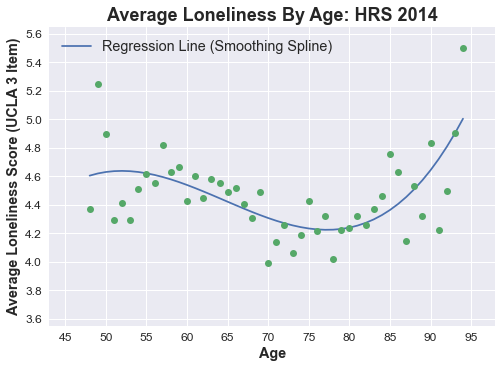

In [60]:
#using apply_spline() to get spline data to plot; chose upper and lower limit based on data available
hrs14_splined = apply_spline(hrs14m, 48, 94)
hrs14_rawx = hrs14_splined[0]
hrs14_rawy = hrs14_splined[1]
hrs14_spline = hrs14_splined[2]

#rendering plot with regression line and actual points
plt.title("Average Loneliness By Age: HRS 2014", fontsize=18, fontweight='bold')
plt.plot(hrs14_rawx, hrs14_spline(hrs14_rawx), label='Regression Line (Smoothing Spline)')
plt.plot(hrs14_rawx, hrs14_rawy, 'o')

plt.xlabel('Age', fontsize='x-large', fontweight='bold')
plt.ylabel('Average Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(45, 100, 5),  fontsize='large')
plt.yticks(ticks=np.arange(3.6, 5.8, .2),  fontsize='large')
plt.xlim(43, 98)
plt.ylim(3.55, 5.65)

plt.legend(fontsize='x-large')
plt.tight_layout
plt.show()

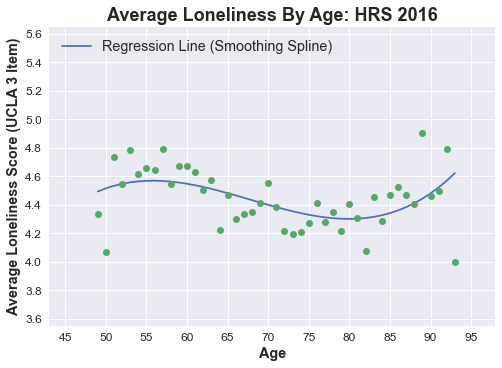

In [61]:
#using apply_spline() to get spline data to plot; chose upper and lower limit based on data available
hrs16_splined = apply_spline(hrs16m, 49, 93)
hrs16_rawx = hrs16_splined[0]
hrs16_rawy = hrs16_splined[1]
hrs16_spline = hrs16_splined[2]

#rendering plot with regression line and actual points
plt.title("Average Loneliness By Age: HRS 2016", fontsize=18, fontweight='bold')
plt.plot(hrs16_rawx, hrs16_spline(hrs16_rawx), label='Regression Line (Smoothing Spline)')
plt.plot(hrs16_rawx, hrs16_rawy, 'o')

plt.xlabel('Age', fontsize='x-large', fontweight='bold')
plt.ylabel('Average Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(45, 100, 5), fontsize='large')
#plt.yticks(ticks=np.arange(3.6, 5.4, .2), fontsize='large')
#plt.xlim(43, 98)
#plt.ylim(3.55, 5.25)

plt.yticks(ticks=np.arange(3.6, 5.8, .2),  fontsize='large')
plt.xlim(43, 98)
plt.ylim(3.55, 5.65)

plt.legend(fontsize='x-large', loc='upper left')
plt.tight_layout
plt.show()

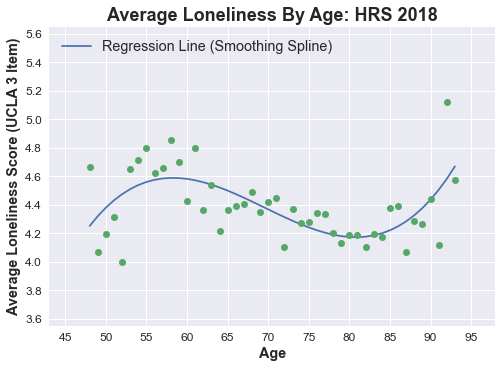

In [62]:
#using apply_spline() to get spline data to plot; chose upper and lower limit based on data available
hrs18_splined = apply_spline(hrs18m, 48, 93)
hrs18_rawx = hrs18_splined[0]
hrs18_rawy = hrs18_splined[1]
hrs18_spline = hrs18_splined[2]

#rendering plot with regression line and actual points
plt.title("Average Loneliness By Age: HRS 2018", fontsize=18, fontweight='bold')
plt.plot(hrs18_rawx, hrs18_spline(hrs18_rawx), label='Regression Line (Smoothing Spline)')
plt.plot(hrs18_rawx, hrs18_rawy, 'o')

plt.xlabel('Age', fontsize='x-large', fontweight='bold')
plt.ylabel('Average Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(45, 100, 5), fontsize='large')
#plt.yticks(ticks=np.arange(3.6, 5.4, .2), fontsize='large')
#plt.xlim(43, 98)
#plt.ylim(3.55, 5.25)

plt.yticks(ticks=np.arange(3.6, 5.8, .2),  fontsize='large')
plt.xlim(43, 98)
plt.ylim(3.55, 5.65)

plt.legend(fontsize='x-large', loc='upper left')
plt.tight_layout
plt.show()

## Altarum Survey: Loneliness After Pandemic Restrictions

Below, I use the Altarum survey data to create a simple pie chart to visually present the data.

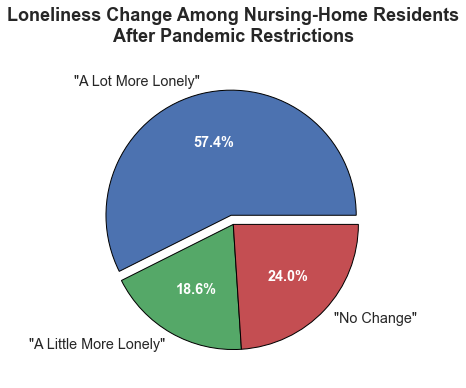

In [63]:
#manipulating dataframe to input into 'plt.pie'
alt_loneliness_series = altarum_loneliness.unstack(1)

#setting labels for each section of the pie chart
labels = ["\"A Lot More Lonely\"", "\"A Little More Lonely\"", "\"No Change\""]

#parameters for explode
explode = [0.075, 0, 0]

#rendering the pie chart with styling
plt.title("Loneliness Change Among Nursing-Home Residents\nAfter Pandemic Restrictions\n", fontsize=18, fontweight='bold')
patches, texts, pcts = plt.pie(alt_loneliness_series, labels=labels, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, 
                            autopct='%1.1f%%', explode=explode, textprops={'size': 'x-large'})
plt.setp(pcts, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

## Altarum Survey: Visitors Before and After Pandemic Restrictions

Below, I use Altarum survey data to create a bar chart that shows the drastic decrease in weekly visitors to nursing homes brought about by the necessary COVID-19 safety restrictions.

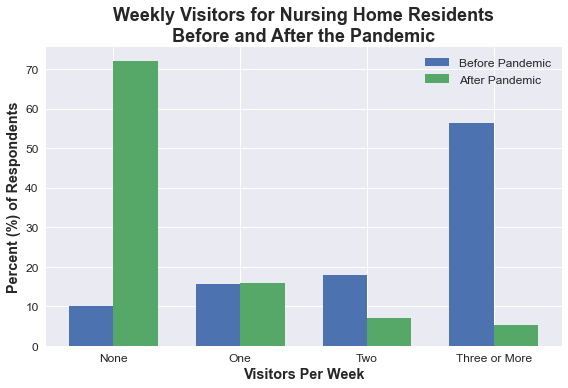

In [64]:
# %matplotlib notebook

#manipulating dataframe to create two series with data for the double bar graph
visitors_pre_rest = altarum_visitors.iloc[0]
visitors_post_rest = altarum_visitors.iloc[1]

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(visitors_pre_rest))
width = 0.35

#rendering double bar graph with styling
plt.title("Weekly Visitors for Nursing Home Residents\nBefore and After the Pandemic", 
                            fontsize=18, fontweight='bold')
plt.bar(x_indexes - width/2, visitors_pre_rest, width=width, label='Before Pandemic')
plt.bar(x_indexes + width/2, visitors_post_rest, width=width, label='After Pandemic')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('Visitors Per Week', fontsize='x-large', fontweight='bold')
plt.ylabel('Percent (%) of Respondents', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['None', 'One', 'Two', 'Three or More'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

## NSHAP: Correlations of Loneliness with Anxiety, Depression, and Percieved Stress

In order to calculate and eventually visually plot correlations, i first index into the NSHAP dataframe in order to separate the needed data into separate series. 

In [65]:
nshap_lscorex = nshap_f['lonely_score']
nshap_ascorey = nshap_f['anxiety_score']
nshap_dscorey = nshap_f['depression_score']
nshap_psscorey = nshap_f['pstress_score']

Below I use largely the same process to calculate and visualize the correlations. I first statsmodels.api.OLS function to caculate the linear regression (and related statistics). After printing the summary statistics, I go on to render the visual representation of such correlations, labeled with their Beta values (correlation coefficient) and p values (in order to tell statistical significance of the correlations). These results are consistent with those published in *The Lancet Public Health* ([Santini, et al.](https://www.sciencedirect.com/science/article/pii/S2468266719302300#bib15)).

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:          anxiety_score   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     335.4
Date:                Tue, 20 Jul 2021   Prob (F-statistic):           3.63e-71
Time:                        11:22:08   Log-Likelihood:                -7736.3
No. Observations:                3053   AIC:                         1.548e+04
Df Residuals:                    3051   BIC:                         1.549e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.4837      0.091    126.218   

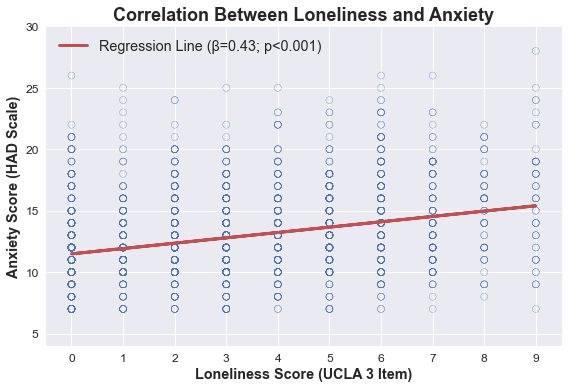

In [66]:
#correlating loneliness score and anxiety score
results = sm.OLS(nshap_ascorey,sm.add_constant(nshap_lscorex)).fit()

#printing linear regression analysis summary
print(results.summary())

#rendering scatter plot with data points and regression line
plt.scatter(nshap_lscorex, nshap_ascorey, facecolors='none', edgecolors='#4c72b0', marker='o')

plt.plot(nshap_lscorex, nshap_lscorex*results.params[1] + results.params[0], label='Regression Line (β=0.43; p<0.001)',
        linewidth=3, color='#c44e52')

plt.title("Correlation Between Loneliness and Anxiety", fontsize=18, fontweight='bold')
plt.xlabel('Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.ylabel('Anxiety Score (HAD Scale)', fontsize='x-large', fontweight='bold')

plt.xticks(ticks=np.arange(0,10), fontsize='large')
plt.yticks(ticks=np.arange(5, 35, 5), fontsize='large')
plt.ylim(4, 30)
plt.xlim(-.5, 9.5)


plt.legend(fontsize='x-large', loc='upper left')
plt.tight_layout()
plt.show()

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:       depression_score   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     568.7
Date:                Tue, 20 Jul 2021   Prob (F-statistic):          2.12e-115
Time:                        11:22:08   Log-Likelihood:                -8184.0
No. Observations:                3053   AIC:                         1.637e+04
Df Residuals:                    3051   BIC:                         1.638e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           18.9596      0.105    179.962   

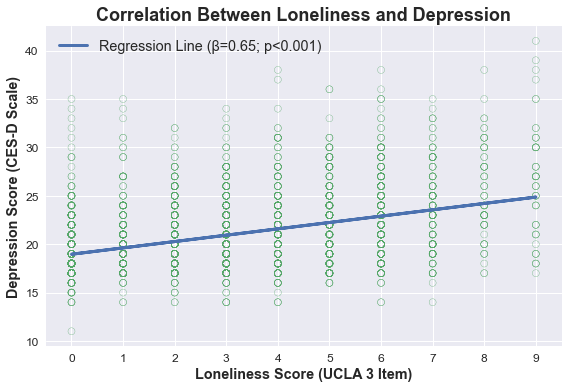

In [67]:
#correlating loneliness score and depression score
results = sm.OLS(nshap_dscorey,sm.add_constant(nshap_lscorex)).fit()

#printing linear regression analysis summary
print(results.summary())

#rendering scatter plot with data points and regression line
plt.scatter(nshap_lscorex, nshap_dscorey, facecolors='none', edgecolors='#55a868', marker='o')

plt.plot(nshap_lscorex, nshap_lscorex*results.params[1] + results.params[0], label='Regression Line (β=0.65; p<0.001)', 
         color='#4c72b0', linewidth=3)

plt.xticks(ticks=np.arange(0,10))
plt.xlim(-.5, 10)

plt.title("Correlation Between Loneliness and Depression", fontsize=18, fontweight='bold')
plt.xlabel('Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.ylabel('Depression Score (CES-D Scale)', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=np.arange(0,11), fontsize='large')
plt.yticks(fontsize='large')
plt.xlim(-.5, 9.5)


plt.legend(fontsize='x-large')
plt.tight_layout()
plt.show()

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:          pstress_score   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     313.7
Date:                Tue, 20 Jul 2021   Prob (F-statistic):           6.85e-67
Time:                        11:22:09   Log-Likelihood:                -7042.6
No. Observations:                3053   AIC:                         1.409e+04
Df Residuals:                    3051   BIC:                         1.410e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.6645      0.072     50.551   

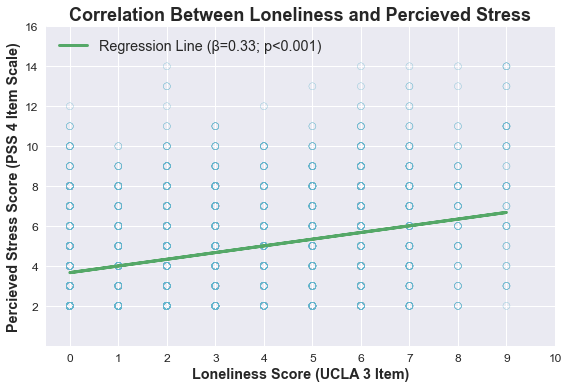

In [68]:
#correlating loneliness score and percieved stress score
results = sm.OLS(nshap_psscorey,sm.add_constant(nshap_lscorex)).fit()

#printing linear regression analysis summary
print(results.summary())

#rendering scatter plot with data points and regression line
plt.scatter(nshap_lscorex, nshap_psscorey, facecolors='none', edgecolors='#64b5cd', marker='o')

plt.plot(nshap_lscorex, nshap_lscorex*results.params[1] + results.params[0], label='Regression Line (β=0.33; p<0.001)',
        linewidth=3, color='#55a868')

plt.xticks(ticks=np.arange(0,11))
plt.xlim(-.5, 10)

plt.title("Correlation Between Loneliness and Percieved Stress", fontsize=18, fontweight='bold')
plt.xlabel('Loneliness Score (UCLA 3 Item)', fontsize='x-large', fontweight='bold')
plt.ylabel('Percieved Stress Score (PSS 4 Item Scale)', fontsize='x-large', fontweight='bold')

plt.xticks(ticks=np.arange(0,11), fontsize='large')
plt.yticks(np.arange(2, 17, 2), fontsize='large')
plt.xlim(-.5, 10)
plt.ylim(0, 16)

plt.legend(fontsize='x-large', loc='upper left')
plt.tight_layout()
plt.show()

## HRS: Physician Visits and Hospital Overnight Stays: Lonely vs Not Lonely

In this section, I find the difference in physician and hospital visits between respondents labeled as lonely and not lonely (see above). I begin by definign a function that, depending on the input column, determines the mean number of visits to a physician OR hospital for both respondents labeled as 'lonely' and those labeled as 'not lonely'. It also calculates a t-test in order to tell if the difference between the two is statistically significant. Note: consistent with other studies, such as one conducted by [Gerst-Emerson & Jayawardhana](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4386514/), I decided to set values higher than the 99th percentile to the 99th percentile. This was done in order to account for the large outliers in the data that would disproportionately alter the means of the data. 

In [69]:
#when using this function, input column argument within single quotations; ex: hrs_visits(hrs12mc, 'NN147', 998, 999)
def hrs_visits(df, column, DK_val, RF_val):
    dfc = df.copy()
    
    #numeric DK_val and RF_val indicate "Don't Know" and "Refused [to answer]" respectively in the data; drop those values
    dfc_clean = dfc[(dfc[column] != DK_val) & (dfc[column] != RF_val)]
    
    #setting values such that values over 99th percentile are replaced with the 99th percentile value
    #this is done in order to control for the disproportionately large outliers within the raw data (ex: '900' physician visits)
    dfc_clean.loc[dfc_clean[column] >= dfc_clean[column].quantile(.99), column] = dfc_clean[column].quantile(.99)
    
    #run a t-test to determine whether the differences between the means of the data are significantly different
    lonely_y = dfc_clean[dfc_clean.lonely_yn == True][column]
    lonely_n = dfc_clean[dfc_clean.lonely_yn == False][column]
    ttest = ttest_ind(lonely_y, lonely_n)

    #return descriptive statistics about the loneliness (count, mean, standard deviation, quarentiles, etc) to be used in plots
    #also return t-test output which includes the t-statistic and p-value (to determine statistical significance)
    lonely_y_describe = lonely_y.describe()
    lonely_n_describe = lonely_n.describe()
    return [lonely_y_describe, lonely_n_describe, ttest]

Below, I run the hrs_visits function and plot a double bar chart to show the apparent difference in physician and hospital overnight stays between those labeled as 'lonely' and those labeled as 'not lonely'. The t-test results are printed below each of the bar charts, separated by the year. The p-values indicate whether the differences in physician visits/hospital stays are statistically significant. These results are consistent with those found by [Gerst-Emerson & Jayawardhana](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4386514/).

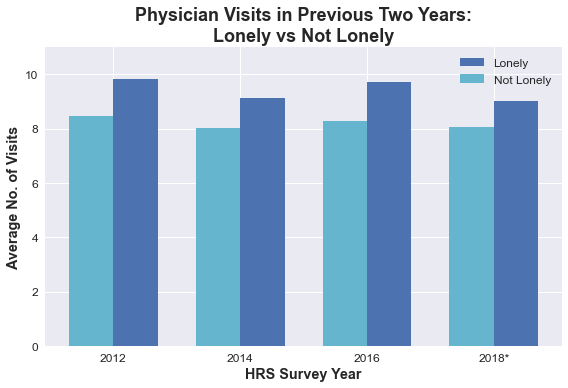

In [74]:
#number of doctor visits: lonely vs not lonely

#putting data through hrs_visits function to find number of doctor visits
hrs12_dvisits = hrs_visits(hrs12m, 'NN147', 998, 999)
hrs14_dvisits = hrs_visits(hrs14m, 'NN147', 998, 999)
hrs16_dvisits = hrs_visits(hrs16m, 'NN147', 998, 999)
hrs18_dvisits = hrs_visits(hrs18m, 'NN147', 998, 999)

#create empty lists to be filled with mean number of visits, separated by whether reported feeling lonely or not
lonely_dvisits = []
nlonely_dvisits = []

#appending data from hrs_visits onto lonely_dvisits and nlonely_dvisits to plot
lonely_dvisits.append(hrs12_dvisits[0]['mean'])
lonely_dvisits.append(hrs14_dvisits[0]['mean'])
lonely_dvisits.append(hrs16_dvisits[0]['mean'])
lonely_dvisits.append(hrs18_dvisits[0]['mean'])

nlonely_dvisits.append(hrs12_dvisits[1]['mean'])
nlonely_dvisits.append(hrs14_dvisits[1]['mean'])
nlonely_dvisits.append(hrs16_dvisits[1]['mean'])
nlonely_dvisits.append(hrs18_dvisits[1]['mean'])

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(lonely_dvisits))
width = 0.35

#rendering double bar graph with styling
plt.title("Physician Visits in Previous Two Years:\nLonely vs Not Lonely", fontsize=18, fontweight='bold')
plt.bar(x_indexes + width/2, lonely_dvisits, width=width, label='Lonely')
plt.bar(x_indexes - width/2, nlonely_dvisits, width=width, label='Not Lonely', color='#64b5cd')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('HRS Survey Year', fontsize='x-large', fontweight='bold')
plt.ylabel('Average No. of Visits', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['2012', '2014', '2016', '2018*'], fontsize='large')
plt.yticks(fontsize='large')
plt.ylim(0, 11)

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

In [71]:
#printing t-test resutlts for doctor visits (small p value indicates statistically significant difference 
#between lonley and not lonley)
print('2012:')
print(hrs12_dvisits[2])
print('\n2014:')
print(hrs14_dvisits[2])
print('\n2016:')
print(hrs16_dvisits[2])
print('\n2018:')
print(hrs18_dvisits[2])

2012:
Ttest_indResult(statistic=4.682497433461286, pvalue=2.889214093673012e-06)

2014:
Ttest_indResult(statistic=4.182034121632336, pvalue=2.9262866862504327e-05)

2016:
Ttest_indResult(statistic=4.7142888725764065, pvalue=2.4841947834182302e-06)

2018:
Ttest_indResult(statistic=3.010009115894673, pvalue=0.0026249895166999613)


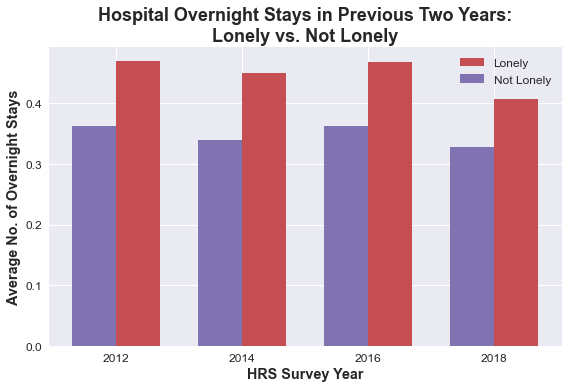

In [72]:
#number of hospital overnight stays: lonely vs not lonely

#create empty lists to be filled with mean number of stays, separated by whether reported feeling lonely or not
lonely_hstays = []
nlonely_hstays = []

#putting data through hrs_visits function to find number of hospital stays
hrs12_hstays = hrs_visits(hrs12m, 'NN100', 98, 99)
hrs14_hstays = hrs_visits(hrs14m, 'NN100', 98, 99)
hrs16_hstays = hrs_visits(hrs16m, 'NN100', 998, 999)
hrs18_hstays = hrs_visits(hrs18m, 'NN100', 998, 999)

#appending data from hrs_visits onto lonely_dvisits and nlonely_dvisits to plot
lonely_hstays.append(hrs12_hstays[0]['mean'])
lonely_hstays.append(hrs14_hstays[0]['mean'])
lonely_hstays.append(hrs16_hstays[0]['mean'])
lonely_hstays.append(hrs18_hstays[0]['mean'])

nlonely_hstays.append(hrs12_hstays[1]['mean'])
nlonely_hstays.append(hrs14_hstays[1]['mean'])
nlonely_hstays.append(hrs16_hstays[1]['mean'])
nlonely_hstays.append(hrs18_hstays[1]['mean'])

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(lonely_hstays))
width = 0.35

#rendering double bar graph with styling
plt.title("Hospital Overnight Stays in Previous Two Years:\nLonely vs. Not Lonely", 
                            fontsize=18, fontweight='bold')
plt.bar(x_indexes + width/2, lonely_hstays, width=width, label='Lonely', color='#c44e52')
plt.bar(x_indexes - width/2, nlonely_hstays, width=width, label='Not Lonely', color='#8172b2')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('HRS Survey Year', fontsize='x-large', fontweight='bold')
plt.ylabel('Average No. of Overnight Stays', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['2012', '2014', '2016', '2018'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

In [73]:
#printing t-test results for hospital stays (small p value indicates statistically significant difference 
#between lonley and not lonley)
print('2012:')
print(hrs12_hstays[2])
print('\n2014:')
print(hrs14_hstays[2])
print('\n2016:')
print(hrs16_hstays[2])
print('\n2018:')
print(hrs18_hstays[2])

2012:
Ttest_indResult(statistic=4.760213552368963, pvalue=1.9722314122990534e-06)

2014:
Ttest_indResult(statistic=5.259334055272588, pvalue=1.4869954256150784e-07)

2016:
Ttest_indResult(statistic=4.3808447099351895, pvalue=1.2019310604063477e-05)

2018:
Ttest_indResult(statistic=3.539974823611652, pvalue=0.00040344072920634323)


## Conclusion

The plots and statistical analysis above were used in the report you can find [HERE](https://projectbluestar.herokuapp.com/our-mission). If you haven't already, I encourage you to read the full report. All feedback is greatly appreciated. You can contact me at fyzeen.ahmad@gmail.com. 